# [DRAFT] Search Location Move AB Test Analysis 

[Task](https://phabricator.wikimedia.org/T267011)

[Megan Neisler](https://meta.wikimedia.org/wiki/User:MNeisler_(WMF)), [Product Analytics](https://www.mediawiki.org/wiki/Product_Analytics) <br/>

December 2020

TODOS:
* Write-up executive summary/key takeways
* Add figure and table numbers for easier referencing in the report
* Review any trends for logged-out users (not included in AB test but received new header location by default on test wikis)
* Review other interesting trends. 

# Contents

1. [Introduction](#Introduction)
2. [Methodology](#Methodology)
3. [Search Sessions Initiated](#Search-Sessions-Initiated)
4. [Search Sessions Completed](#Search-Sessions-Completed)

# Introduction

The Wikimedia Foundation's [Web team](https://www.mediawiki.org/wiki/Readers/Web/Team) is working on researching and building out improvements to the desktop experience to make Wikimedia wikis more welcoming and to increase the utility amongst readers while maintainubg utulity for existing editors.

As part of this effort, the Web team deployed a new location of the search bar, moving the search bar to a more prominent location on the top of the page. The team ran an A/B test of the new location from 20 October 2020 through 4 November 2020 to assess the efficacy of this feature. The test included all logged-in users on the early adopter wikis (Basque Wikipedia, French Wikipedia, French Wiktionary, Hebrew Wikipedia, Persian Wikipedia, and Portuguese Wikiversity). In the test, 50% of logged-in users saw the search bar in the new location, while the other 50% continued to see the search bar in the previous location. 

The new location was also deployed as default for anonymous users on our early adopter wikis, and by preference for all other users.

FIXME: 
* INSERT EXAMPLE IMAGE OF SEARCH MOVE
* INSERT FLOW CHART SHOWING LOCATION DISPLAYED TO EACH TYPE OF USER 

The primary goal of the AB Test was to test the hypothesis that the group with the search bar in the new location will initate more search sessions. The target was identified as 2.5% overall increase in search sessions initiated. The other primary questions we wanted to answer are:

* Which group has a higher rate of search sessions completed? How does this differ per wiki?
* Have any other interesting search trends emerged?
* For logged-out users, are there any perceived changes in search behavior before/after the change?


Upon conclusion of the test on  4 November 2020, a total of 61,602 search sessions had been initiated across both groups. You can find more information on this change and other feature deployments on the [desktop improvement project page](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements).


# Methodology

The AB test  was a run on a per wiki basis and users included in the test were randomly assigned to either the control (search header in the old location) or treatment (search header in the new location) using their user ID and received the same treatment the duration of the test. 

Data was collected in the [SearchSatisfaction](https://meta.wikimedia.org/wiki/Schema:SearchSatisfaction) event logging table.  

See the following Phabricator tickets for furhter details regarding the instrumentation and implementation of the AB test.
* A/B test set-up [T259250](https://phabricator.wikimedia.org/T259250).
* A/B test deployment [T263032](https://phabricator.wikimedia.org/T263032)
* SearchSatisfaction Instrumentation changes [T256100](https://phabricator.wikimedia.org/T256100)
* AB test end [T265333](https://phabricator.wikimedia.org/T265333)


In [386]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(BCDA); library(binom); library(magrittr); library(knitr);
    library(dplyr); library(coda); library(fable)
})

# Search Sessions Initiated

A search session begins when a person starts typing in the search widget. We measured the number of unique search sessions started for each search location type and wiki included in the AB Test. 

We initally considered using a [Welch two-sample t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) to determine if there is statistical difference between the two means; however, since there are only 6 observations (each wiki serves as a single observation in this case), there was not enough evidence to confirm a difference between the number of search sessions initiated between the two groups.  

As an alternative, we conducted a pre and post deployment analysis comparing changes in search sessions intiated for the 6 test wikis to a set of similar wikis not included in the test from 6 October 2020 through 3 November 2020 (two weeks before and after deployment of the change).

We selected similar Wiki projects to each of the test wikis for comparison. These Wikis were selected based on their size (number of articles) and desktop pageview traffic during the reviewed time period.

| Test Wiki | Similar Wikis |
|---------|-----------------|
| Basque Wikipedia  | Slovenian Wikipedia, Belarusian Wikipedia |
| French Wikipedia  | German Wikpedia           |
| French Wikitionary | Russian Wiktionary, Spanish Wiktionary              |
| Hebrew Wikipedia      |  Catalan Wikipedia, Danish Wikipedia, Romanian Wikipedia              |
| Persian Wikipedia      |   Arabic Wikipedia, Indonesian Wikipedia              |
| Portuguese Wikiversity      |  Japanese Wikiversity               |

Note: For wikis not included in the AB test, the new search location was displayed for all users that had enabled the new vector skin in their user preferences. In the analysis below, I removed these users that had enabled the new search location by only reviewing search sessions initatiated on the old ('legacy') vector skin.

## Search Session Data

In [3]:
# collect all autocomplete searches by search location for test wikis and similar wikis
query <- 
" 
SELECT
    min(CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0'))) AS session_start,
    event.searchSessionId AS search_session,
    event.isAnon AS is_anonymous,
    wiki AS wiki,
    event.skinVersion as skin_version,
-- wikis in test and similar wikis
    CASE
        WHEN (wiki IN('euwiki', 'frwiki', 'hewiki', 'ptwikiversity', 'frwiktionary', 'fawiki') AND event.skinVersion = 'latest') THEN 'Wiki projects in AB test'
        WHEN (wiki IN ('slwiki', 'bewiki', 'dewiki', 'ruwiktionary', 'eswiktionary', 'cawiki',
            'da.wikipedia', 'rowiki', 'arwiki', 'idwiki', 'jawikiversity') AND event.skinVersion = 'legacy') THEN 'Wiki projects not in AB test' 
        ELSE 'NA'
        END AS test_group,
    IF(event.inputLocation = 'header-moved', 'new_location', 'old_location') AS search_location,
    Count(*) AS events
FROM event.searchSatisfaction 
WHERE 
-- review two week period before and after deployment
    year = 2020 
    AND ((month = 10 and day >= 05) OR (month = 11 and day < 04)) 
--  all search widget session searches
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
    AND wiki IN ('euwiki', 'frwiki', 'hewiki', 'ptwikiversity', 'frwiktionary', 'fawiki',
    'slwiki', 'bewiki', 'dewiki', 'ruwiktionary', 'eswiktionary', 'cawiki',
    'da.wikipedia', 'rowiki', 'arwiki', 'idwiki', 'jawikiversity')
-- only review sessions on vector 
    AND event.skin = 'vector'
-- remove bots
    AND useragent.is_bot = false
    AND event.inputLocation IN ('header-moved', 'header-navigation')
    AND event.subTest IS NULL
GROUP BY 
    event.searchSessionId,
    event.isAnon,
    wiki,
    event.skinVersion,
    CASE
        WHEN (wiki IN('euwiki', 'frwiki', 'hewiki', 'ptwikiversity', 'frwiktionary', 'fawiki') AND event.skinVersion = 'latest') THEN 'Wiki projects in AB test'
        WHEN (wiki IN ('slwiki', 'bewiki', 'dewiki', 'ruwiktionary', 'eswiktionary', 'cawiki',
            'da.wikipedia', 'rowiki', 'arwiki', 'idwiki', 'jawikiversity') AND event.skinVersion = 'legacy') THEN 'Wiki projects not in AB test' 
        ELSE 'NA'
        END,
    IF(event.inputLocation = 'header-moved', 'new_location', 'old_location')"



In [4]:
collect_search_session_data <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [5]:
collect_search_session_data$session_start <- as.Date(collect_search_session_data$session_start, format = "%Y-%m-%d")

In [6]:
# add logged in status column

search_sessions <- collect_search_session_data %>%
 mutate(logged_in_status = case_when(
        is_anonymous == 'NULL' ~ "unknown", # some NULL records were recorded prior to deployment of isAnon field
        is_anonymous == 'false'~ "logged-in",
        is_anonymous == 'true' ~ "logged-out"))
 

## Search Sessions Initiated Counts Per Group and Wiki

In [8]:
search_sessions_ab_bywiki <- search_sessions %>%
    # Review only users included in AB test
    filter(logged_in_status == 'logged-in',
          test_group == 'Wiki projects in AB test',
          session_start >= '2020-10-20') %>% # AB test rereun on October 20
    group_by(wiki, search_location) %>%
    summarize(sessions = length(unique(search_session)), .groups = "drop") 

In [9]:
session_counts <- search_sessions_ab_bywiki %>%
    xtabs(sessions ~ wiki + search_location, data = .) %>%
    addmargins

In [10]:
session_counts %>%
  as.data.frame.matrix %>%
  set_colnames(c("New Search Location (Treatment)", "Old Search Location (Control)", "Both Groups")) %>%
  set_rownames(c("Basque Wikipedia", "Persian Wikipedia", "French Wikipedia", "French Wikitionary", 
                "Hebrew Wikipedia", "Portuguese Wikiversity", "All 6 wikis")) 


,New Search Location (Treatment),Old Search Location (Control),Both Groups
,<dbl>,<dbl>,<dbl>
Basque Wikipedia,872,649,1521
Persian Wikipedia,2527,2457,4984
French Wikipedia,22750,26235,48985
French Wikitionary,1943,1709,3652
Hebrew Wikipedia,1047,1394,2441
Portuguese Wikiversity,12,7,19
All 6 wikis,29151,32451,61602


In [11]:
options(repr.plot.width = 15, repr.plot.height = 10)

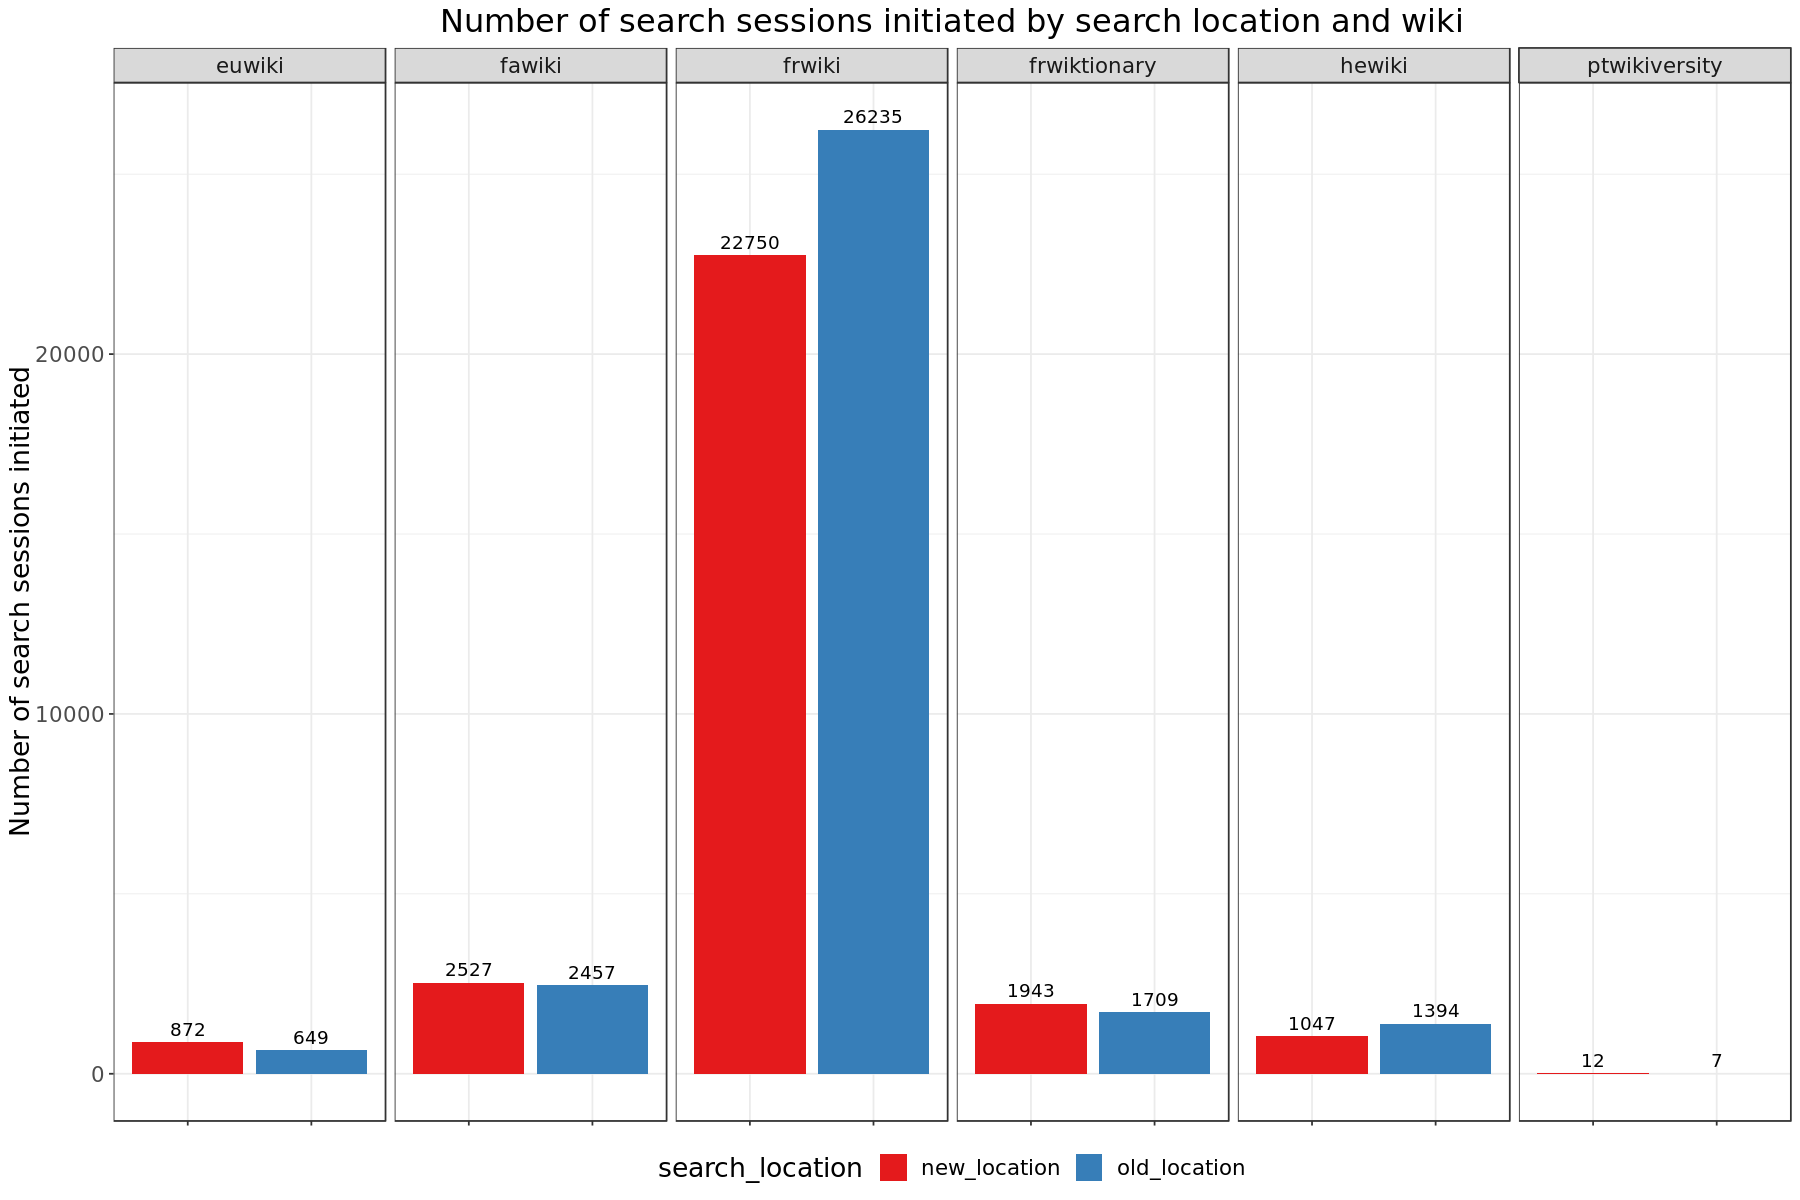

In [12]:
# plot number of sessions per wiki for comparison

p <- search_sessions_ab_bywiki  %>%
        ggplot(aes(x=search_location, y= sessions, fill = search_location)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(sessions)), vjust=-0.5) +
        facet_grid(~wiki) +
        labs (y = "Number of search sessions initiated",
              x = "Group",
             title = "Number of search sessions initiated by search location and wiki")  +
        theme_bw() +
        scale_fill_brewer(palette="Set1")  +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")
      
p
ggsave("Figures/search_sessions_initiated_totals.png", p, width = 16, height = 8, units = "in", dpi = 300)

The total number of distinct search sessions initiated range from 48985 search sessions on French Wikipedia to only 19 search sessions on Portuguese Wikiverity. 

The test group with the higher number of search sessions initiated varies for each test Wiki.Basque Wikipedia, Persian Wikipedia, French Wikitionary, and Portuguese Wikiversity had more search sessions initiated when the search widget was displayed in the new location while French Wikipedia and Hebrew Wikipedia had more search sessions initated when the search widget was displayed in the previous location.


## Distribution of Search Sessions Initiated

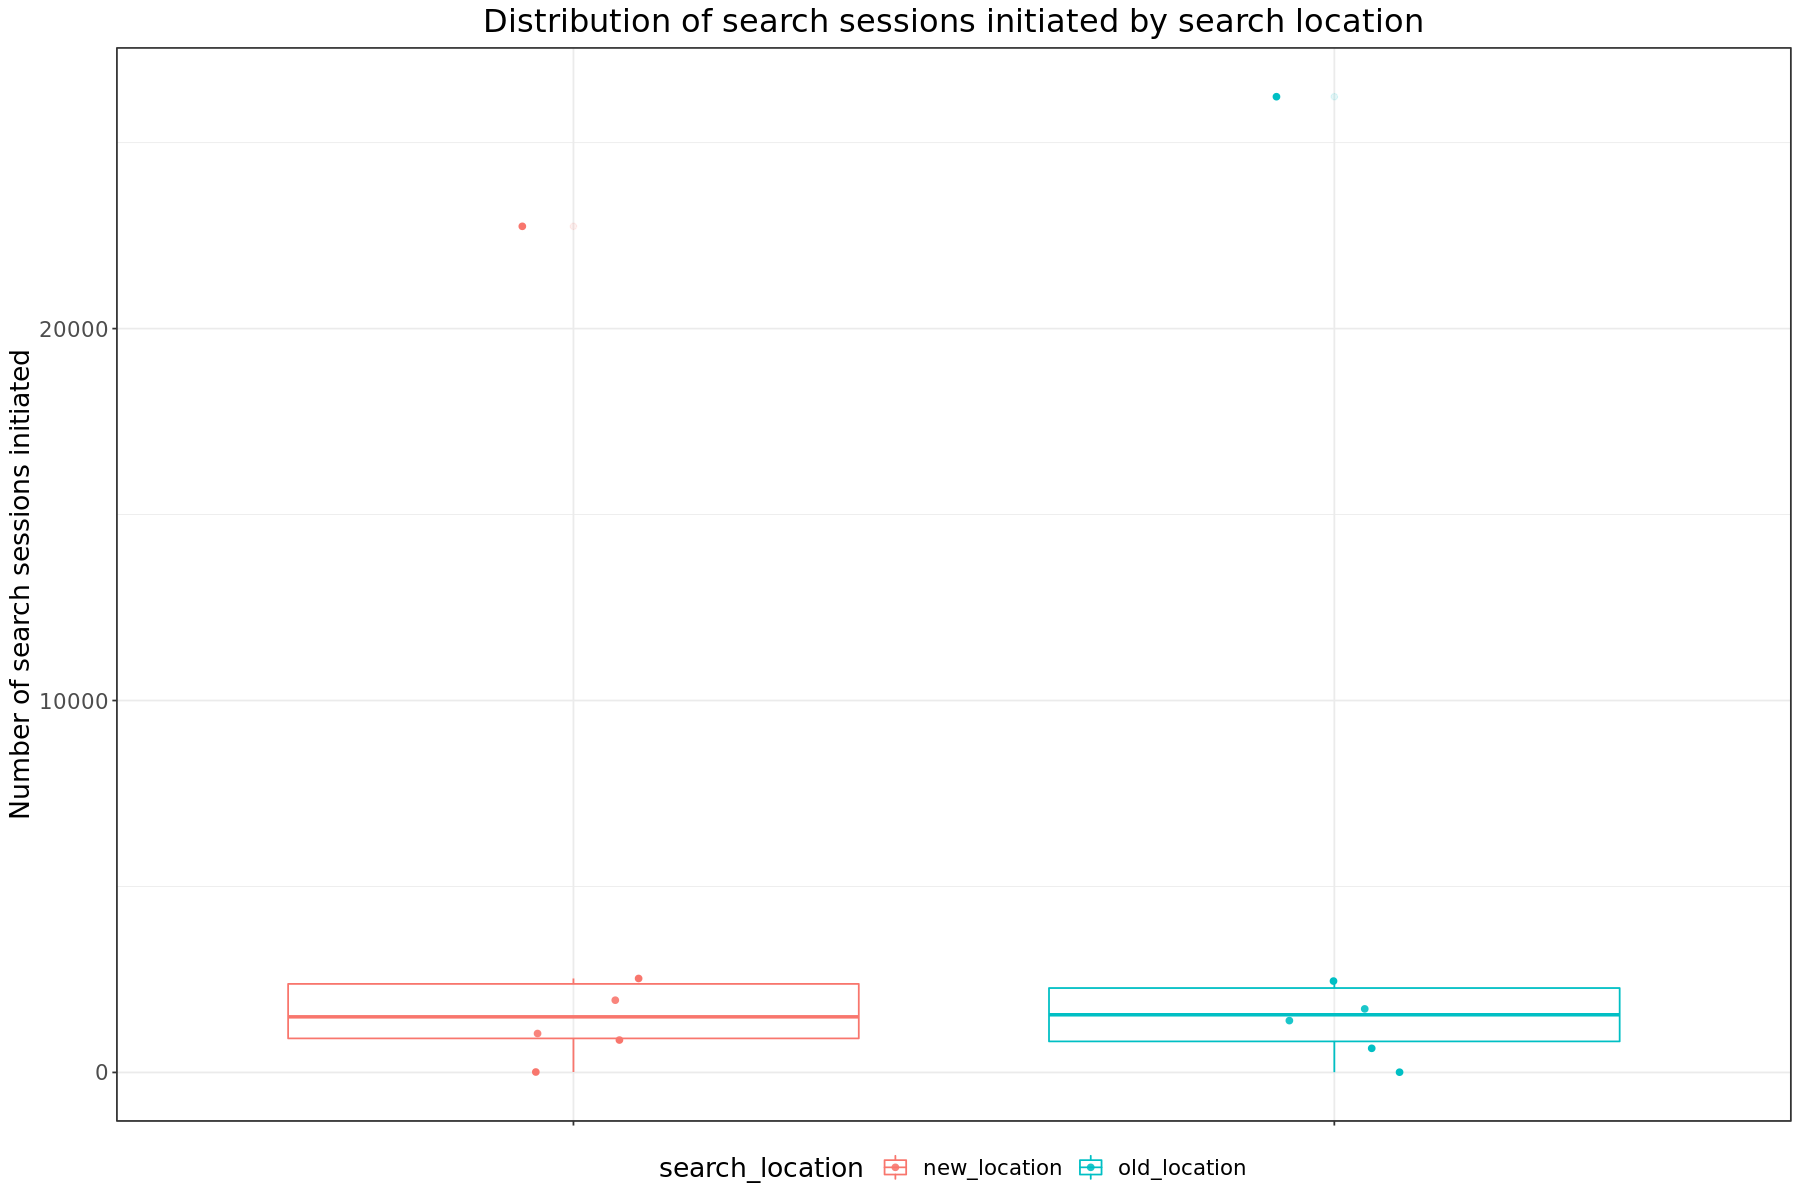

In [14]:

p <- ggplot(search_sessions_ab_bywiki, aes(x = search_location, y = sessions, color = search_location)) +
  geom_jitter(height = 0, width = 0.1) +
  geom_boxplot(alpha = 0.1) +
    labs (y = "Number of search sessions initiated",
            x = "Group",
         title = "Distribution of search sessions initiated by search location")  +
         theme_bw() +
         scale_fill_brewer(palette="Set1")  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
       legend.position = "bottom")
      
p
ggsave("Figures/search_sessions_initiated_boxplot.png", p, width = 16, height = 8, units = "in", dpi = 300)

The plot above shows the distribution of the search sessions intiated. The sessions initiated for French Wikipedia are significantly higher than the sessions initiated for the other test wikis.


## Search Sessions Initiated Pre and Post AB Test Deployment

We reviewed all search sessions initiated on the test wikis for a two week period before and after the AB test and compared search session intiated on similar size wikis over the same time period to determine any impact from the AB test.

Unfortunately, we are unable to identify logged in or anonymous users prior to 20 October 2020 when the`isAnon` field was added to the SearchSatisfaction schema and the AB test was started.  As a result, we reviewed both logged-in and logged-out users when comparing search sessions intiated pre and post deployment of the AB test; however, only logged-in users were included in the AB test. Logged-out users on the test wikis received the new search location by default. 

FIXME: Detail implications of this to the results.


In [15]:
# search sessions intiated per day and test group
search_sessions_daily <- search_sessions %>%
    filter(test_group != 'NA') %>% # removes users not in either test group 
    group_by(session_start, test_group, search_location) %>%
    summarize(sessions = length(unique(search_session)), .groups = "drop") 

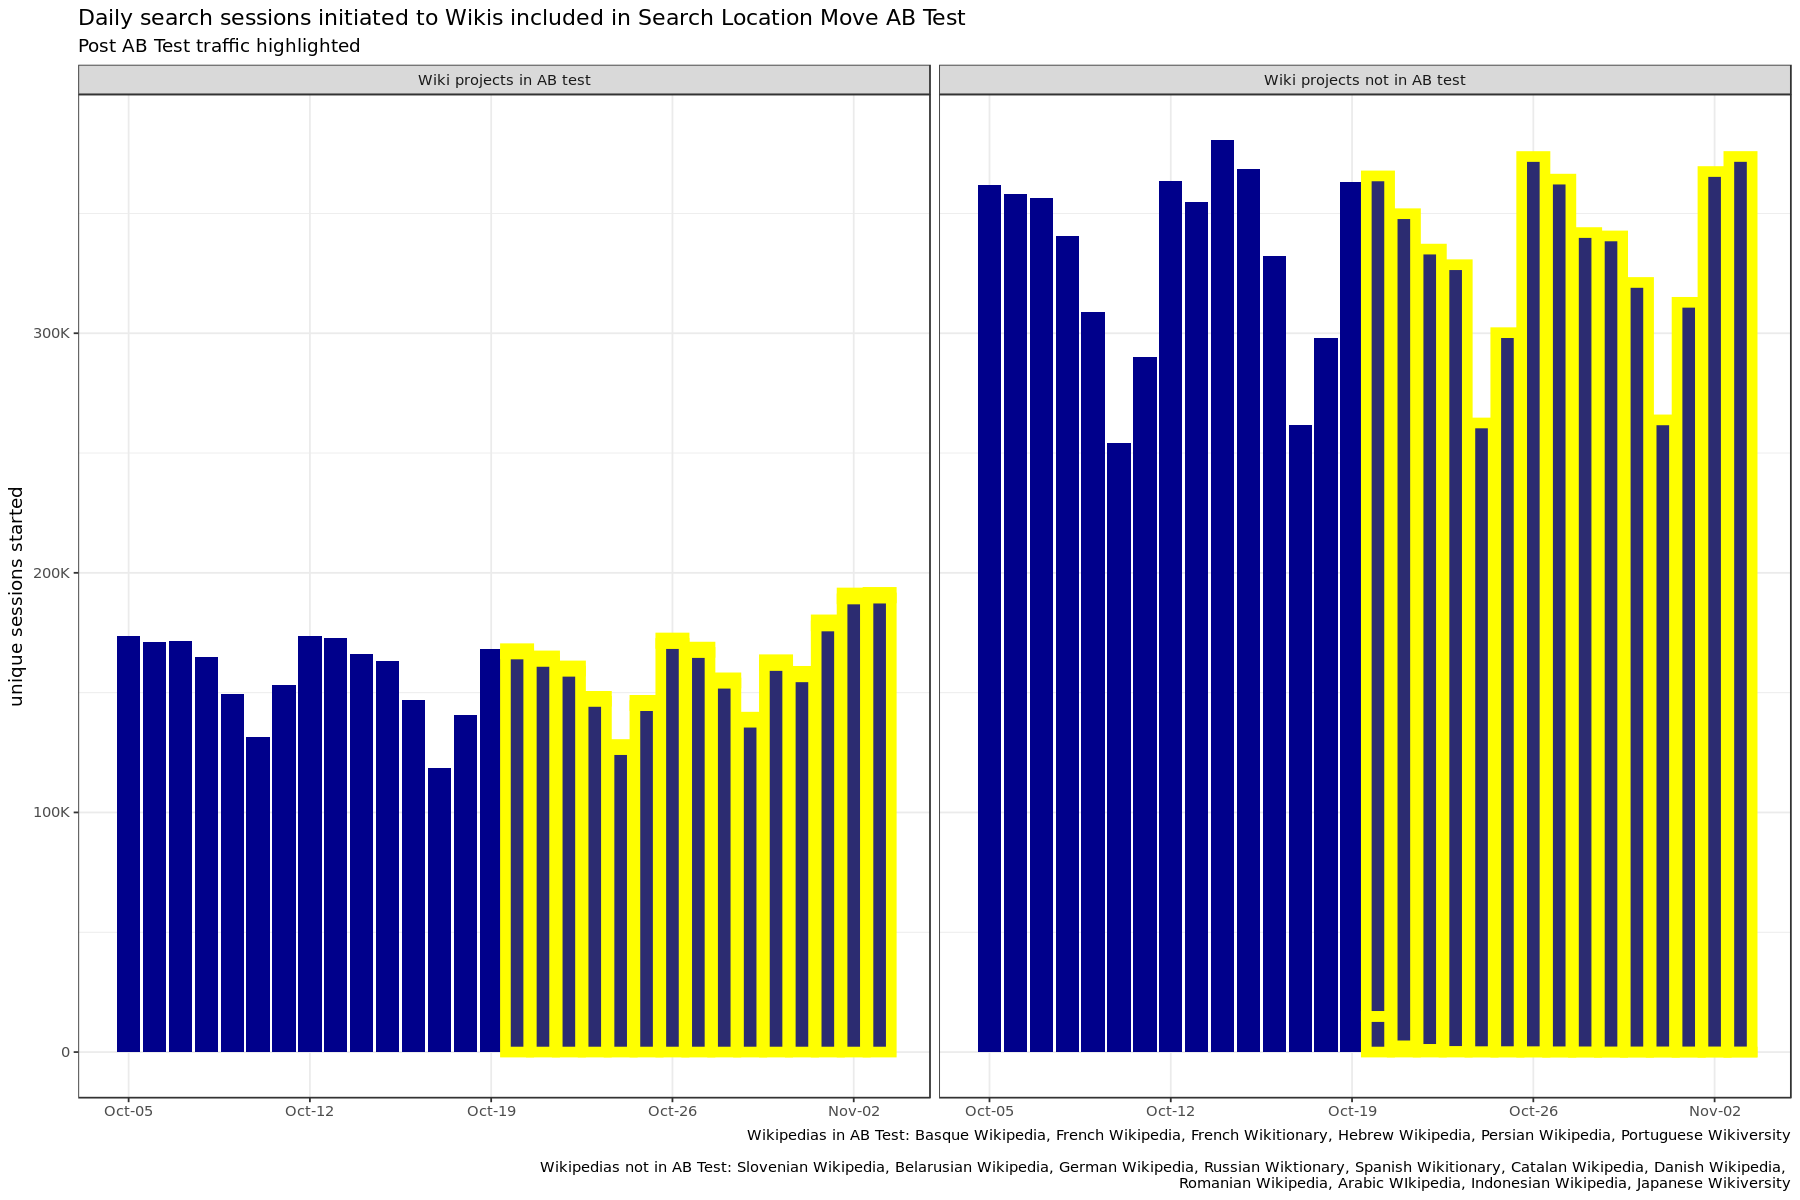

In [16]:
# Plot per test group comparison

p <- search_sessions_daily %>%
    ggplot( aes(x = session_start, y = sessions)) +
    geom_col( fill = 'darkblue') +
    geom_col(
    data = filter(search_sessions_daily, session_start >= "2020-10-20"),
    alpha = 0.5, color = "yellow", size = 3
  ) +
  facet_grid(~ test_group) +
  scale_x_date(date_labels = "%b-%d", date_breaks = "1 week", minor_breaks = NULL) +
  scale_y_continuous(labels = polloi::compress) +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = NULL, y = "unique sessions started",
    title = "Daily search sessions initiated to Wikis included in Search Location Move AB Test",
    subtitle = "Post AB Test traffic highlighted",
    caption = "Wikipedias in AB Test: Basque Wikipedia, French Wikipedia, French Wikitionary, Hebrew Wikipedia, Persian Wikipedia, Portuguese Wikiversity
      \n Wikipedias not in AB Test: Slovenian Wikipedia, Belarusian Wikipedia, German Wikipedia, Russian Wiktionary, Spanish Wikitionary, Catalan Wikipedia, Danish Wikipedia, 
        Romanian Wikipedia, Arabic WIkipedia, Indonesian Wikipedia, Japanese Wikiversity"
 ) +
  theme(legend.position = "bottom") + 
  theme_bw()

p
ggsave("Figures/daily_search_sessions_initiated_prepost.png", p, width = 16, height = 8, units = "in", dpi = 300)

Overall, there appears to be no significant change in daily search sessions initiated following deployment of the AB test on the test wikis. 

We fit a linear regression model to identify the relationship between the search sessions initiated pre deployment of the AB test and post deployment of the AB test as well as the impact of the AB test.

In [17]:
# pre and post data by test group and wiki
search_sessions_bywiki <- search_sessions %>%
    filter(test_group != 'NA') %>%  # removes users not in either test group
    mutate(deploy_status = if_else(session_start < '2020-10-20', 'pre', 'post'),
          )  %>%
    group_by(wiki, test_group, deploy_status) %>%
    summarise(num_sessions = n_distinct(search_session), .groups = "drop") %>%
    ungroup() %>%
    spread(deploy_status, num_sessions)


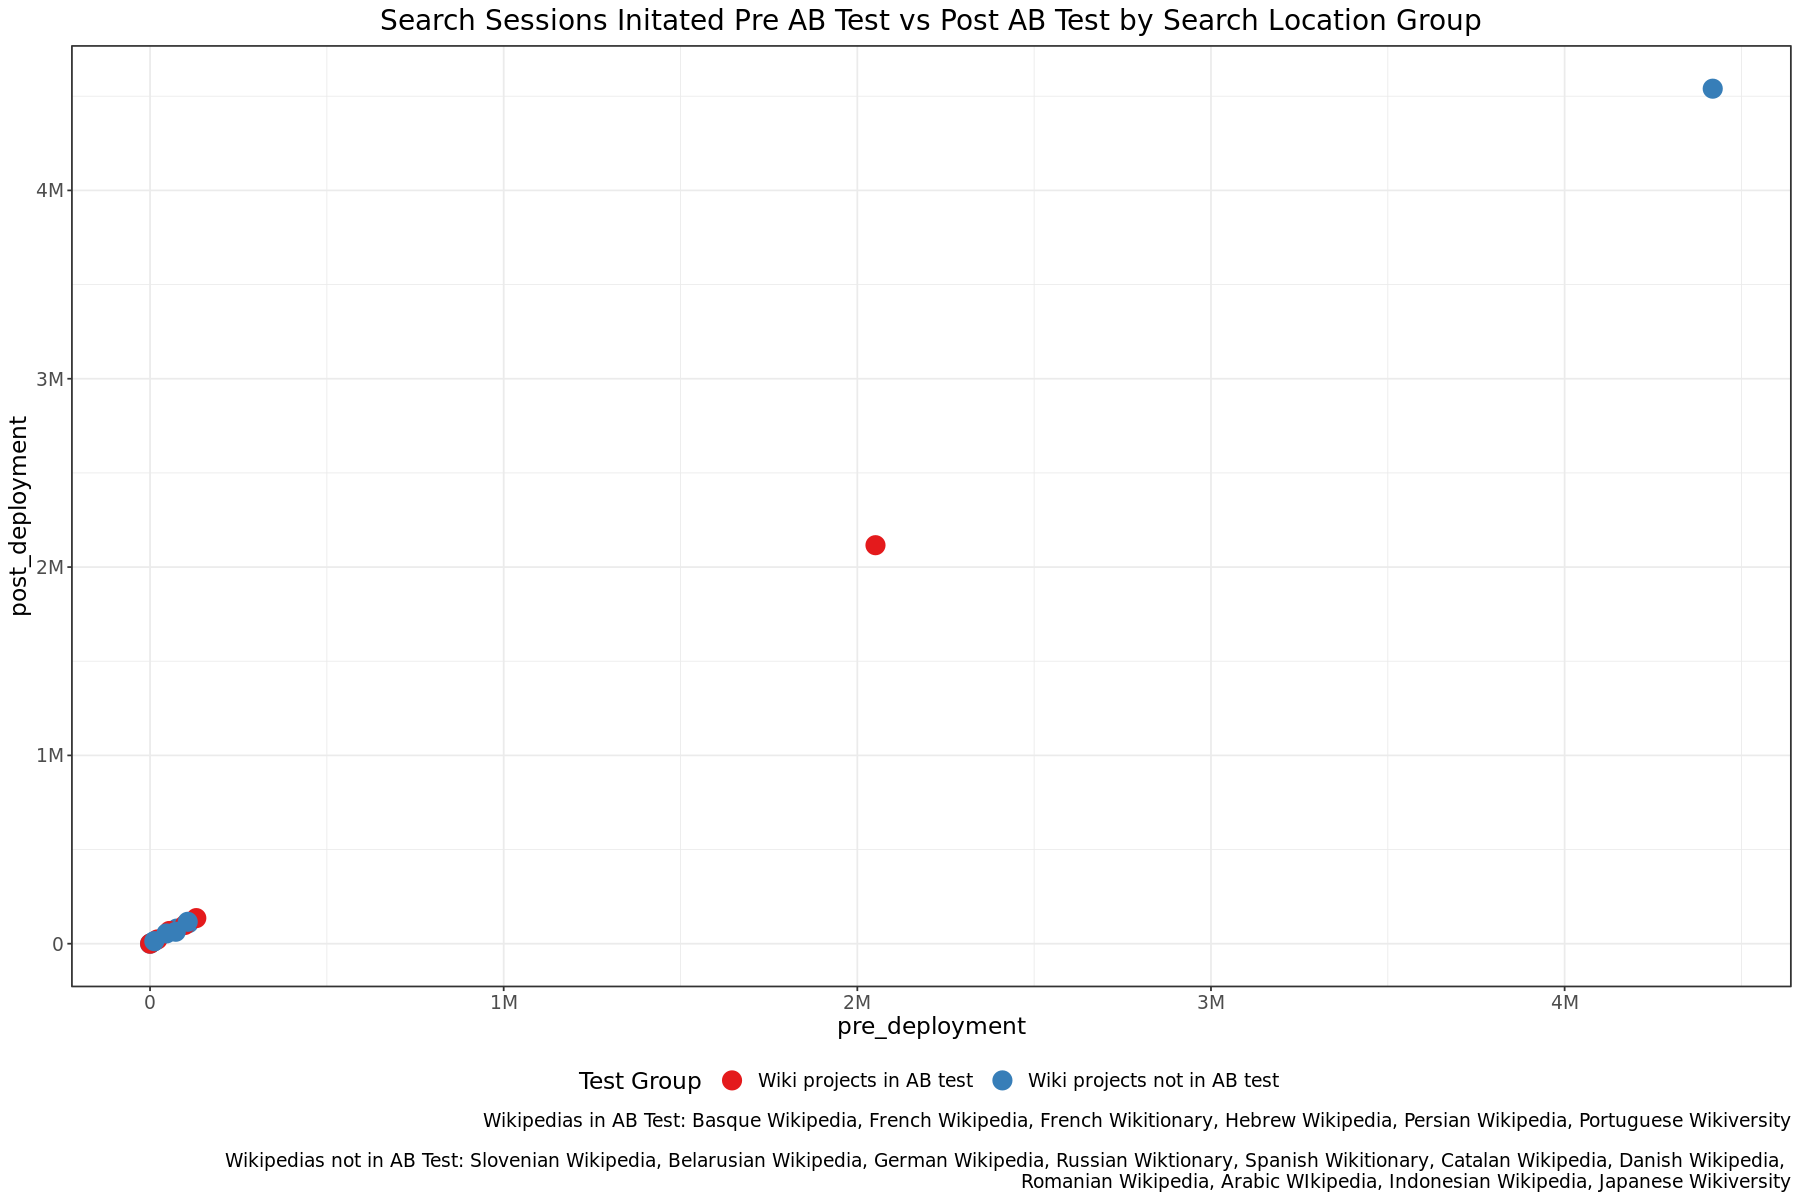

In [18]:
p <- search_sessions_bywiki %>%
      ggplot( aes(x = pre, y = post, color = factor(test_group))) +
      geom_point(size = 5) +
      scale_x_continuous(labels = polloi::compress) +
      scale_y_continuous(labels = polloi::compress) +
      scale_color_brewer(palette = "Set1") +
      labs(
        x = "pre_deployment", y = "post_deployment",
        title = "Search Sessions Initated Pre AB Test vs Post AB Test by Search Location Group",
        caption = "Wikipedias in AB Test: Basque Wikipedia, French Wikipedia, French Wikitionary, Hebrew Wikipedia, Persian Wikipedia, Portuguese Wikiversity
      \n Wikipedias not in AB Test: Slovenian Wikipedia, Belarusian Wikipedia, German Wikipedia, Russian Wiktionary, Spanish Wikitionary, Catalan Wikipedia, Danish Wikipedia, 
        Romanian Wikipedia, Arabic WIkipedia, Indonesian Wikipedia, Japanese Wikiversity",
        colour = "Test Group") +
        theme_bw() +
      theme(legend.position = "bottom",
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14))  
      
p
ggsave("Figures/search_sessions_initiated_pre_v_post.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [19]:
fit <- lm(post ~ pre + test_group, data = search_sessions_bywiki)
summary(fit)


Call:
lm(formula = post ~ pre + test_group, data = search_sessions_bywiki)

Residuals:
   Min     1Q Median     3Q    Max 
-11548  -2398   -184   3011   8165 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                             3.410e+03  2.224e+03   1.533    0.149
pre                                     1.028e+00  1.177e-03 873.566   <2e-16
test_groupWiki projects not in AB test -3.113e+03  2.754e+03  -1.130    0.279
                                          
(Intercept)                               
pre                                    ***
test_groupWiki projects not in AB test    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5329 on 13 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.821e+05 on 2 and 13 DF,  p-value: < 2.2e-16


The pre deployment data is strongly correlated with the post deployment data for both test groups, indicating no noticable impact from the Search AB Test on the number of search sessions initiated.

The t-values indicate that the pre deployment data is a much more signficant predictor than inclusion in the AB test for the post-deployment search sessions initiated. Therefore, we do not think the AB test has any signficant impact on search sessions initiated.

Note that the effect from the AB test is dampened because it was only deployed to 50% of users as part of the AB test.

FIXME:
* Expand write-up
* Consider removing outlier Wikis from linear regression model. The large wikis included in the analysis (frwiki and dewiki) are making it difficult to see any pattern for the smaller wikis.


# Search Sessions Completed

We also reviewed all search sessions in the AB test that included a click to one of the results returned and shown in the Search Result Page. We reviewed both the number of sessions that included at least one click and the total number of clicks per search events for each of the test wikis and overall. Data was restricted to only sessions that had more than zero results returned to them.

We used the internally-developed Bayesian Categorical Data Analysis (BCDA) (Popov, n.d.) package for Bayesian statistical analysis and confidence intervals.

FIXME: Review methodology and make sure all data assumptions are identified.


## Clickthrough Data

In [20]:
query <- "
-- collect all AB test sessions with at least on click event
WITH clicks AS (
SELECT
    event.searchSessionId AS click_session,
    wiki AS click_wiki,
    COUNT(*) AS click_events
FROM event.searchSatisfaction
WHERE
    -- ab test restarted on Oct 20th when isAnon field was added
    year = 2020 
    AND ((month = 10 and day >= 20) OR (month = 11 and day < 04)) 
    AND event.action = 'click'
    AND event.source = 'autocomplete'
    -- review test wikis
    AND wiki IN ('euwiki', 'frwiki', 'hewiki', 'ptwikiversity', 'frwiktionary', 'fawiki')
    -- deployed on on the new vector skin
    AND event.skinVersion = 'latest'
    AND event.skin = 'vector'
-- remove bots
    AND useragent.is_bot = false 
GROUP BY 
    event.searchSessionId,
    wiki
),

-- all search sessions from AB test
searches AS (

SELECT
    IF(event.inputLocation = 'header-moved', 'new_location', 'old_location') AS search_location,
    event.isAnon AS is_anonymous,
    event.searchSessionId AS search_session,
    wiki AS search_wiki,
       CASE
        WHEN event.hitsReturned > 0 THEN 'TRUE'
        WHEN event.hitsReturned = 0 THEN 'FALSE'
        ELSE NULL
        END AS results_returned,
    COUNT(*) AS search_events
FROM event.searchSatisfaction 
WHERE 
-- ab test restarted on Oct 20th when isAnon field was added
    year = 2020 
    AND ((month = 10 and day >= 20) OR (month = 11 and day < 04)) 
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
    AND event.inputLocation IN ('header-moved', 'header-navigation')
-- remove events that were logged prior to isAnon field addition
    AND event.isAnon IS NOT NULL
-- review test wikis
    AND wiki IN ('euwiki', 'frwiki', 'hewiki', 'ptwikiversity', 'frwiktionary', 'fawiki')
-- deployed on on the new vector skin
    AND event.skinVersion = 'latest'
    AND event.skin = 'vector'
-- remove bots
    AND useragent.is_bot = false 
GROUP BY 
    IF(event.inputLocation = 'header-moved', 'new_location', 'old_location') ,
    event.isAnon,
    event.searchSessionId,
    wiki,
    CASE
        WHEN event.hitsReturned > 0 THEN 'TRUE'
        WHEN event.hitsReturned = 0 THEN 'FALSE'
        ELSE NULL
        END 
)
--Main Query--
SELECT
    search_location,
    is_anonymous,
    search_session,
    search_wiki,
    results_returned,
    sum(search_events) AS search_events,
    SUM(CAST(click_events is NOT NULL as int)) AS click_events,
    SUM(CAST(click_session IS NOT NULL AS int)) = 1 AS is_clickthrough_session
FROM searches
LEFT JOIN clicks ON
    searches.search_session = clicks.click_session AND
    searches.search_wiki = clicks.click_wiki 
GROUP BY 
    search_location,
    is_anonymous,
    search_session,
    results_returned,
    search_wiki"

In [21]:
collect_ctr_data <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [22]:
collect_ctr_data$click_events <- as.integer(collect_ctr_data$click_events)

# Clickthroughs by Session

We first reviewed the number of sessions with at least one clickthrough to a provided search result. 

## Overall

In [24]:
# Sessions that clicked through by treatment group overall

sessions_ctr_overall <- collect_ctr_data %>%
    filter(results_returned == TRUE, # remove searches with zero results
            is_anonymous == 'false') %>%  # remove anon users not included in the AB test
   with(table(search_location, is_clickthrough_session))

sessions_ctr_overall 


               is_clickthrough_session
search_location false  true
   new_location   883 26992
   old_location   894 30065

In [27]:
bcda_sessions_ctr_overall <- BCDA::beta_binom(sessions_ctr_overall) %>%
    print(interval_type = "HPD") 

           term   estimate    std.error     conf.low   conf.high
1            p1 0.03170860 0.0010530073 2.962925e-02 0.033751792
2            p2 0.02890353 0.0009574682 2.703887e-02 0.030772351
3     prop_diff 0.00280507 0.0014295277 2.325686e-05 0.005583232
4 relative_risk 1.09826486 0.0517692924 1.000768e+00 1.202816700
5    odds_ratio 1.10152417 0.0535457166 1.000890e+00 1.209764317


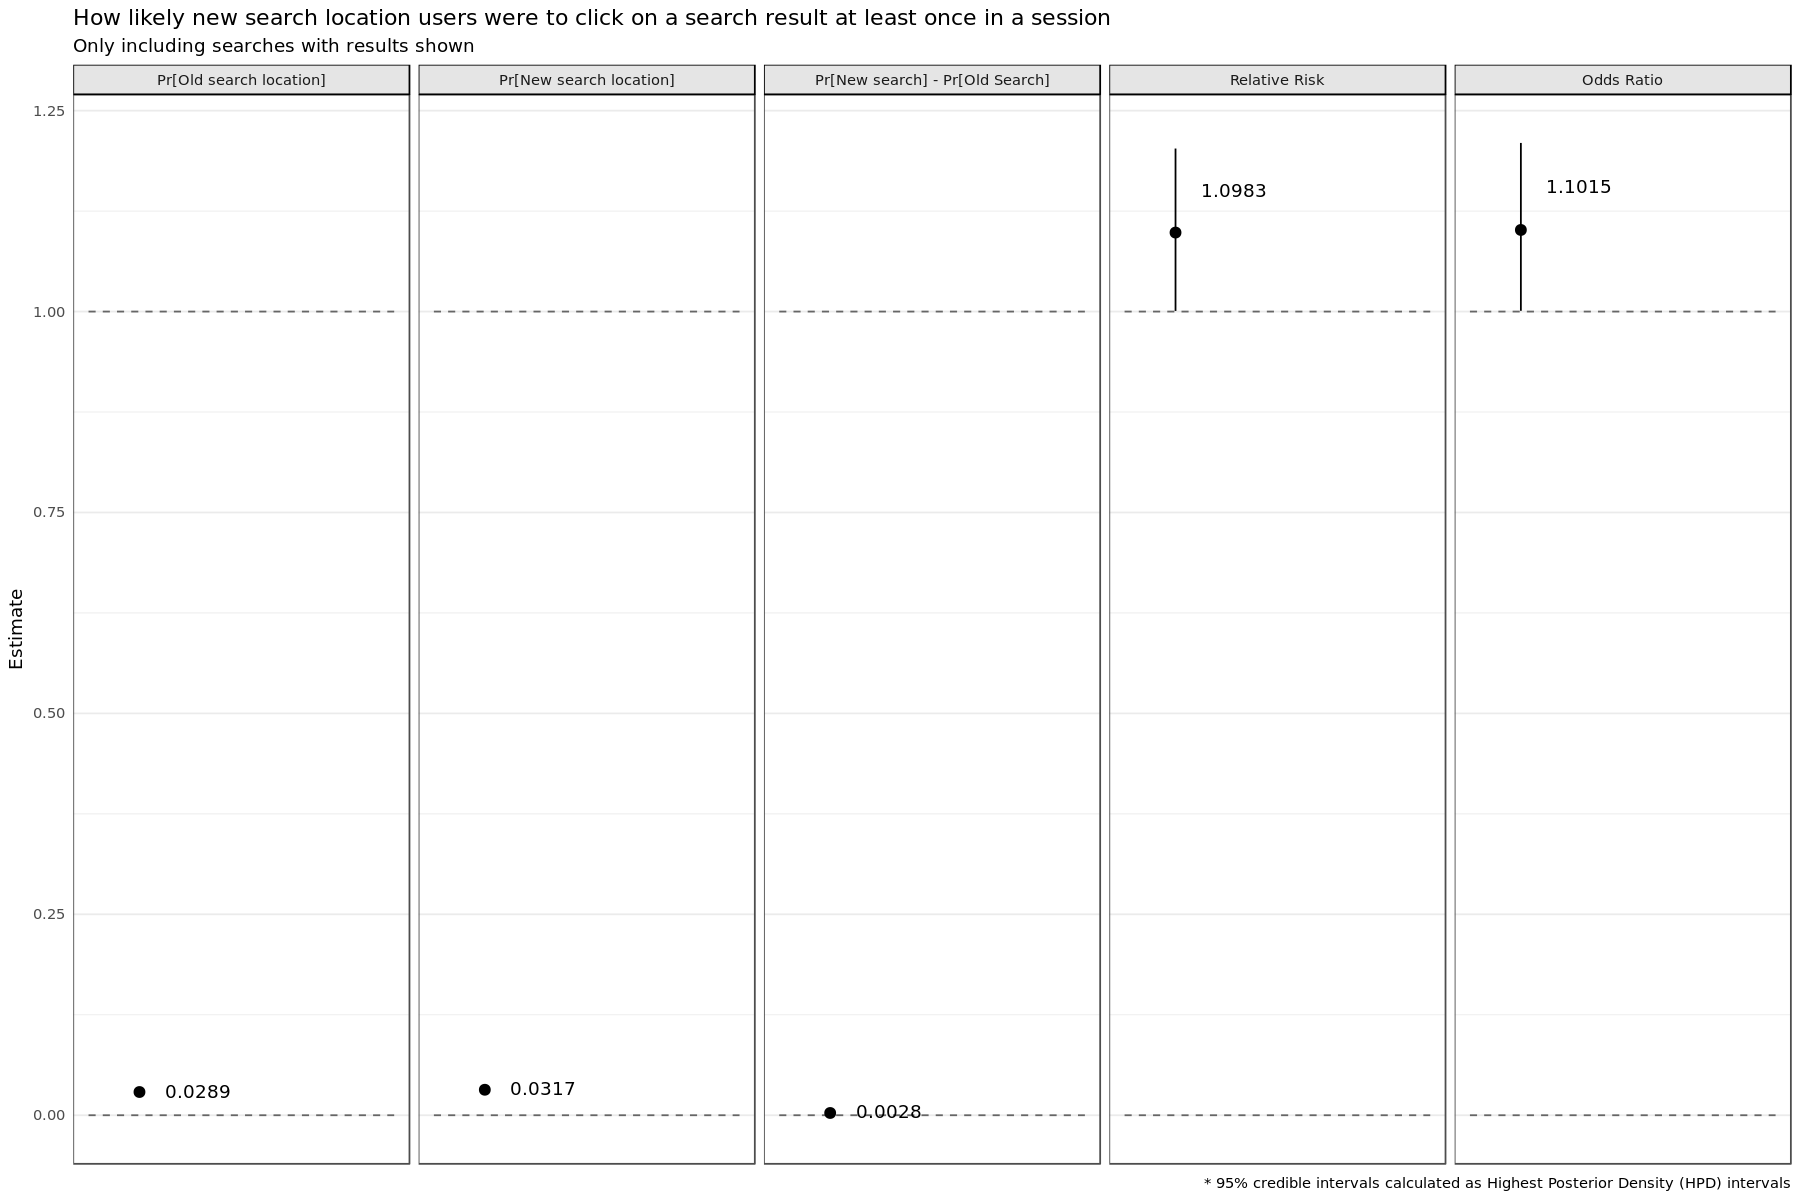

In [28]:
p <- bcda_sessions_ctr_overall %>%
  mutate(term = factor(
    term,
    levels = c("p2", "p1", "prop_diff", "relative_risk", "odds_ratio"),
    labels = c("Pr[Old search location]", "Pr[New search location]", "Pr[New search] - Pr[Old Search]", "Relative Risk", "Odds Ratio")
  )) %>%
  ggplot(aes(x = 1, y = estimate, ymin = conf.low, ymax = conf.high)) +
  geom_segment(y = 1, yend = 1, x = 0.99, xend = 1.05, linetype = "dashed", color = "gray40") +
  geom_segment(y = 0, yend = 0, x = 0.99, xend = 1.05, linetype = "dashed", color = "gray40") +
  geom_pointrange() +
  geom_text(aes(label = round(estimate, 4), y = estimate + (conf.high - estimate)/2,
                hjust = "left"), nudge_x = 0.005) +
    facet_grid(~ term ) +
  theme_minimal(base_family = "GillSans") +
  scale_x_continuous(limits = c(0.99, 1.05)) +
  theme(legend.position = "bottom",
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        strip.background = element_rect(fill = "gray90"),
        panel.border = element_rect(color = "gray30", fill = NA),
        strip.text.y = element_text(size = 12, angle = 0)) +
  labs(x = NULL, y = "Estimate",
       title = "How likely new search location users were to click on a search result at least once in a session",
       subtitle = "Only including searches with results shown",
       caption = "* 95% credible intervals calculated as Highest Posterior Density (HPD) intervals")

p
ggsave("Figures/bcda_sessions_ctr_overall.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [29]:
list(
  "Test vs Control" = filter(bcda_sessions_ctr_overall, term == "relative_risk")) %>%
     dplyr::bind_rows(.id = "Comparison") %>%
     mutate(ci = sprintf("(%.3f, %.3f)", conf.low, conf.high),
            rr =  sprintf("%.3f", estimate)) %>%
     select(Comparison,
         `Relative Risk` = rr,
         `95% CI` = ci) 

Comparison,Relative Risk,95% CI
<chr>,<chr>,<chr>
Test vs Control,1.098,"(1.001, 1.203)"


Users that saw the new search location are 1.099 times more likely to click on at least 1 search result in a session compared to users in the control.

FIXME:
* Expand text to clarify results shown above. 


## By Wiki

In [30]:
# Sessions that clicked through by wiki and search location

searches_ctr_bysession_wiki <- collect_ctr_data  %>%
    filter(results_returned == TRUE, # remove searches with zero results
            is_anonymous == 'false') %>% # remove anon users not included in the AB test
    group_by(search_wiki, search_location) %>%
    summarize(sessions = n_distinct(search_session), 
            clickthroughs = sum(is_clickthrough_session == 'true'), .groups = "drop") %>%
    group_by(search_wiki, search_location) %>%
    dplyr::do(binom::binom.bayes(.$clickthroughs, .$sessions, conf.level = 0.95))


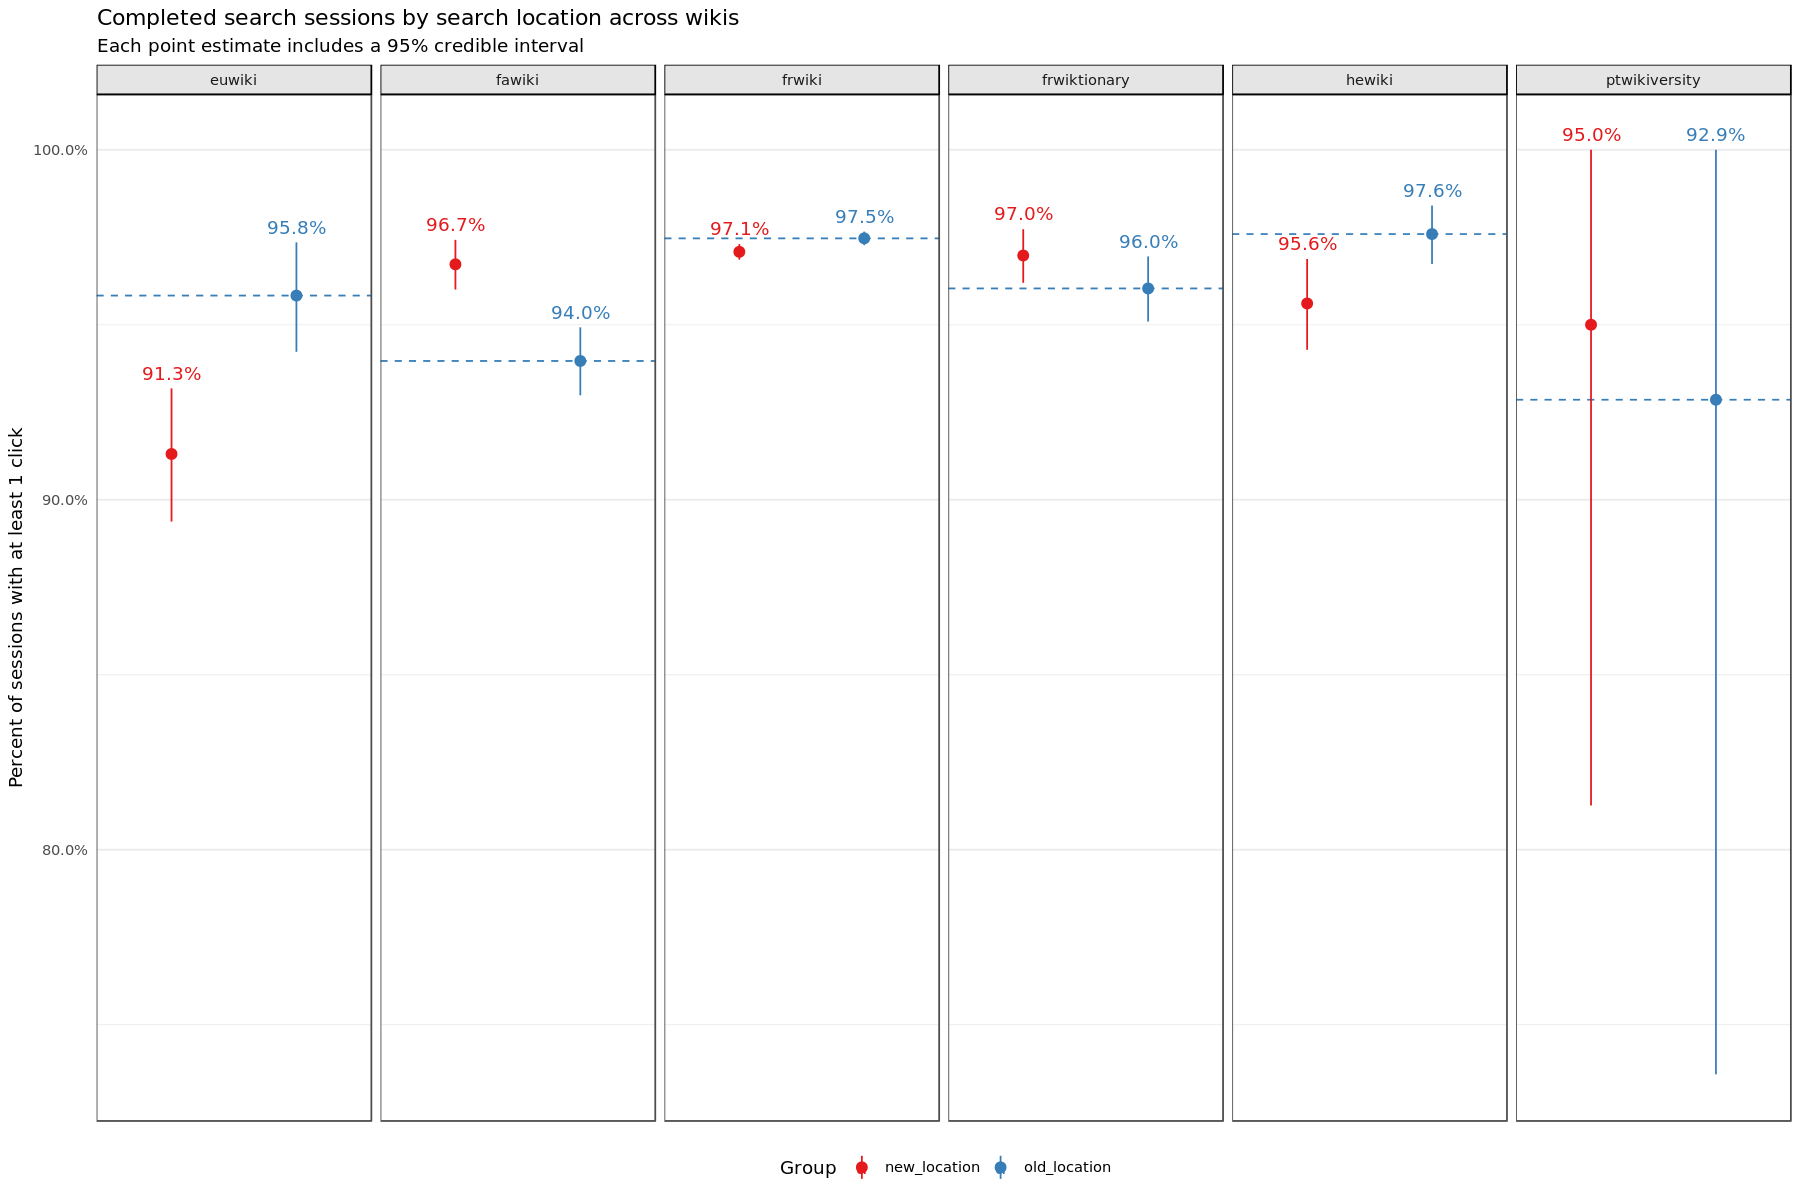

In [32]:
p <- searches_ctr_bysession_wiki %>%
  ggplot(aes(x = 1, color = search_location, y = mean, ymin = lower, ymax = upper)) +
  geom_hline(aes(yintercept = mean), linetype = "dashed", color = RColorBrewer::brewer.pal(3, "Set1")[2],
             data = filter(searches_ctr_bysession_wiki, search_location == "old_location")) +
  geom_pointrange(position = position_dodge(width = 0.5)) +
  geom_text(aes(label = sprintf("%.1f%%", 100 * mean), y = upper + 0.0025, vjust = "bottom"),
            position = position_dodge(width = 0.5)) +
  facet_wrap(~ search_wiki, nrow = 1) +
  scale_color_brewer("Group", palette = "Set1") +
  scale_y_continuous("Percent of sessions with at least 1 click", labels = scales::percent_format()) +
  theme_minimal(base_family = "GillSans") +
  theme(legend.position = "bottom",
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        strip.background = element_rect(fill = "gray90"),
        panel.border = element_rect(color = "gray30", fill = NA)) +
  labs(x = NULL, 
       title = "Completed search sessions by search location across wikis",
       subtitle = "Each point estimate includes a 95% credible interval"
       )

p
ggsave("Figures/searches_ctr_bysession_wiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [33]:
bcda_ctr_bysession_wiki <- searches_ctr_bysession_wiki %>%
  arrange(search_wiki, desc(search_location)) %>%
  group_by(search_wiki) %>%
  dplyr::do(BCDA::tidy(BCDA::beta_binom(.$x, .$n), interval_type = "HPD")) %>%
  ungroup()

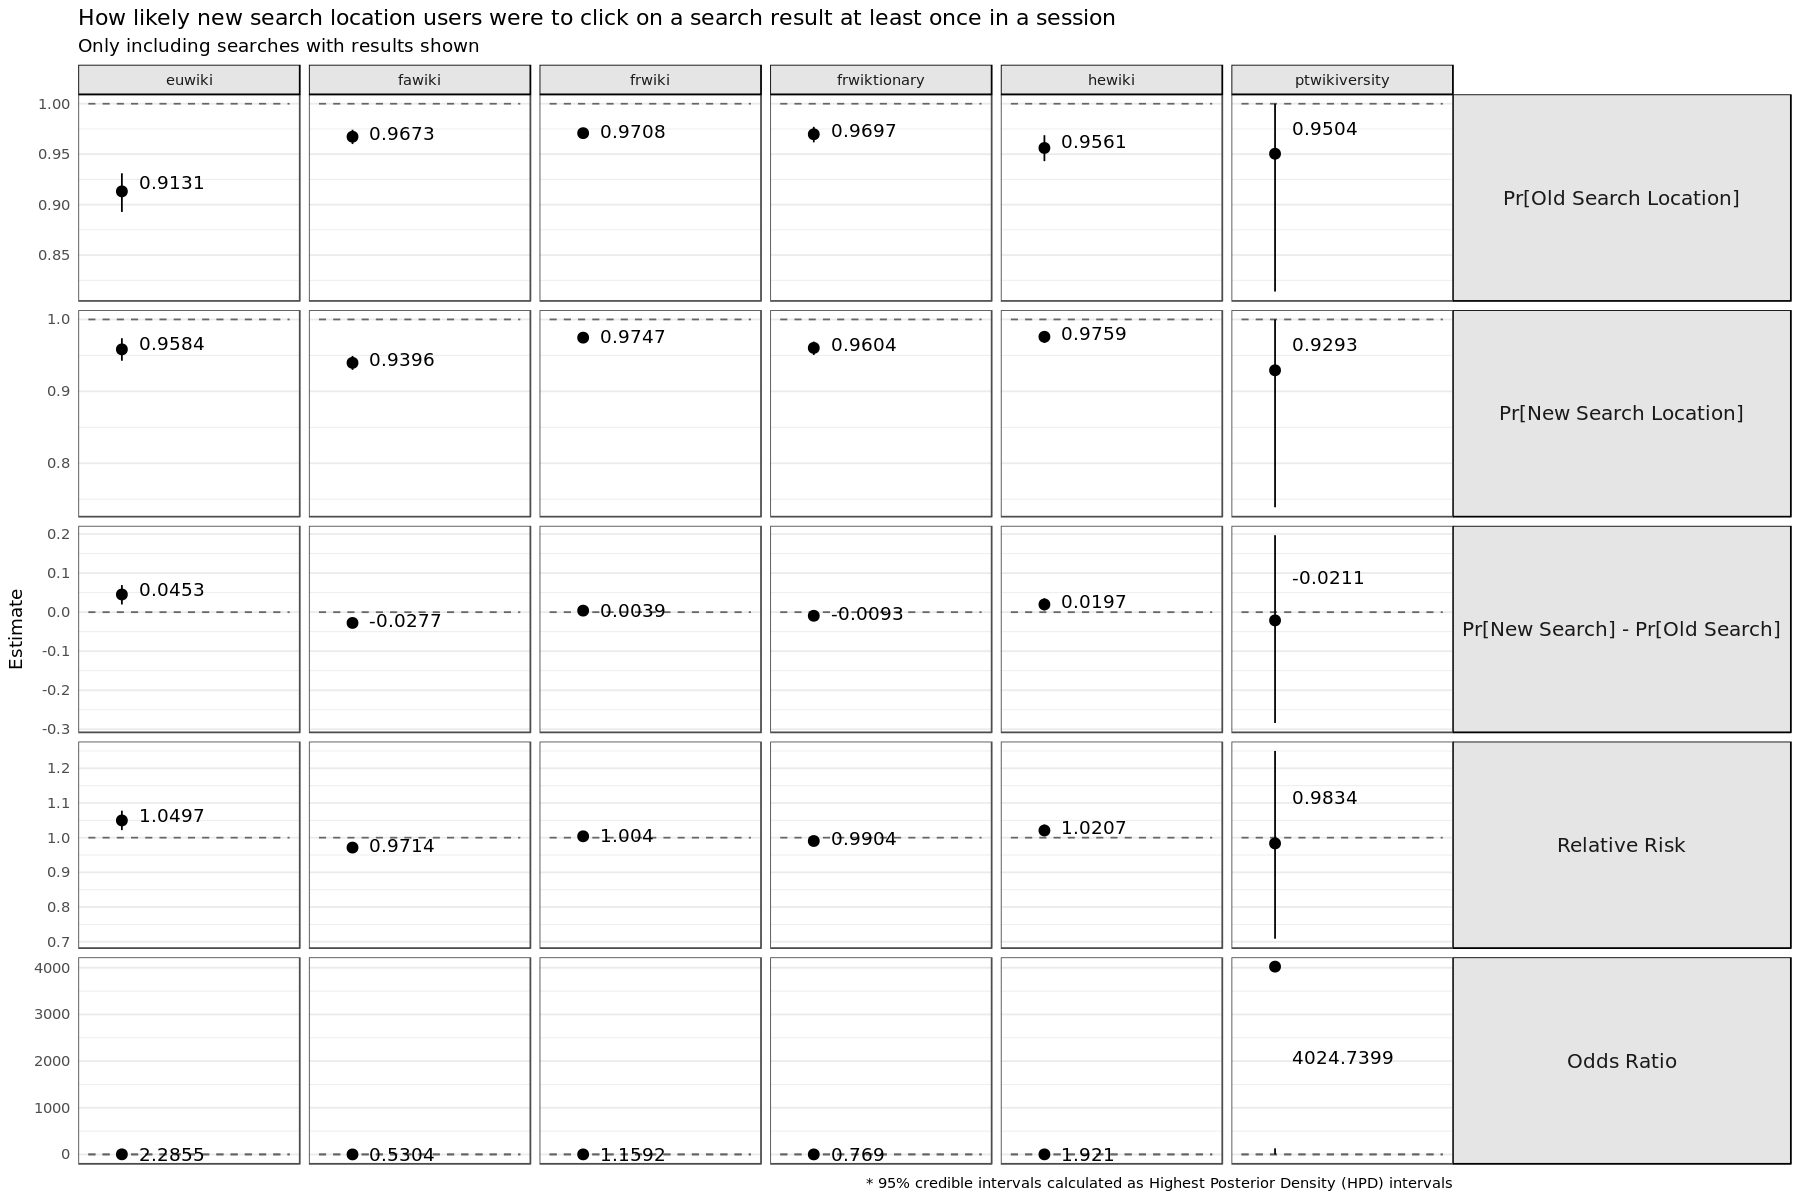

In [34]:
p <- bcda_ctr_bysession_wiki %>%
  mutate(term = factor(
    term,
    levels = c("p2", "p1", "prop_diff", "relative_risk", "odds_ratio"),
    labels = c("Pr[Old Search Location]", "Pr[New Search Location]", "Pr[New Search] - Pr[Old Search]", "Relative Risk", "Odds Ratio")
  )) %>%
  ggplot(aes(x = 1, y = estimate, ymin = conf.low, ymax = conf.high)) +
  geom_segment(y = 1, yend = 1, x = 0.99, xend = 1.05, linetype = "dashed", color = "gray40") +
  geom_segment(y = 0, yend = 0, x = 0.99, xend = 1.05, linetype = "dashed", color = "gray40") +
  geom_pointrange() +
  geom_text(aes(label = round(estimate, 4), y = estimate + (conf.high - estimate)/2,
                hjust = "left"), nudge_x = 0.005) +
  facet_grid(term ~ search_wiki, scales = "free_y") +
  theme_minimal(base_family = "GillSans") +
  scale_x_continuous(limits = c(0.99, 1.05)) +
  theme(legend.position = "bottom",
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        strip.background = element_rect(fill = "gray90"),
        panel.border = element_rect(color = "gray30", fill = NA),
        strip.text.y = element_text(size = 12, angle = 0)) +
  labs(x = NULL, y = "Estimate",
       title = "How likely new search location users were to click on a search result at least once in a session",
       subtitle = "Only including searches with results shown",
       caption = "* 95% credible intervals calculated as Highest Posterior Density (HPD) intervals")
p
ggsave("Figures/bcda_ctr_bysession_wiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [35]:
list(
  "Test vs Control" = filter(bcda_ctr_bysession_wiki, term == "relative_risk")) %>%
     dplyr::bind_rows(.id = "Comparison") %>%
     mutate(ci = sprintf("(%.3f, %.3f)", conf.low, conf.high),
         rr =  sprintf("%.3f", estimate)) %>%
     select(Wiki = search_wiki,
         `Relative Risk` = rr,
         `95% CI` = ci) %>%
     arrange(Wiki) 

Wiki,Relative Risk,95% CI
<chr>,<chr>,<chr>
euwiki,1.050,"(1.022, 1.078)"
fawiki,0.971,"(0.959, 0.983)"
frwiki,1.004,"(1.001, 1.007)"
frwiktionary,0.990,"(0.978, 1.003)"
hewiki,1.021,"(1.004, 1.038)"
ptwikiversity,0.983,"(0.709, 1.250)"


On a per wiki basis, there were more completed search sessions (defined by sessions with at least 1 click to search result) for the new search location than the old search location on Persian Wikipedia and French Wiktionary while the clickthrough rates were lower on Hebrew Wikipedia, Basque Wikipedia, and French Wikipedia.

Since Portuguese Wikiversity only had 19 observed sessions during the test period, we are not able to reliably determine if the new search location had an impact on clickthrough rates observed on this Wiki. 

The Table above shows the relative risk or how much more likely each respective test group is to click results in the new search location (test group) than the old search location (control group). For example, on French Wikipedia, users that saw the new header location are about 1.004 times more likely to click on at least one result during a session than users that saw the old header location.

# Clickthroughs by Searches

We also reviewed clickthrough rate defined as the total number of clicks divided by the numbers of searches overall and by wiki as an alternate measure of user engagement with the provided results. 


In [36]:
searches_counts <- collect_ctr_data  %>%
  filter(results_returned == TRUE,
        is_anonymous == 'false') %>%
  group_by(search_wiki, search_location) %>%
  summarize(`Average searches\n per session` = mean(search_events), 
            `Average clicks\n per session` = mean(click_events), .groups = "drop") %>%
  ungroup %>%
  tidyr::gather(metric, value, -c(search_wiki, search_location))


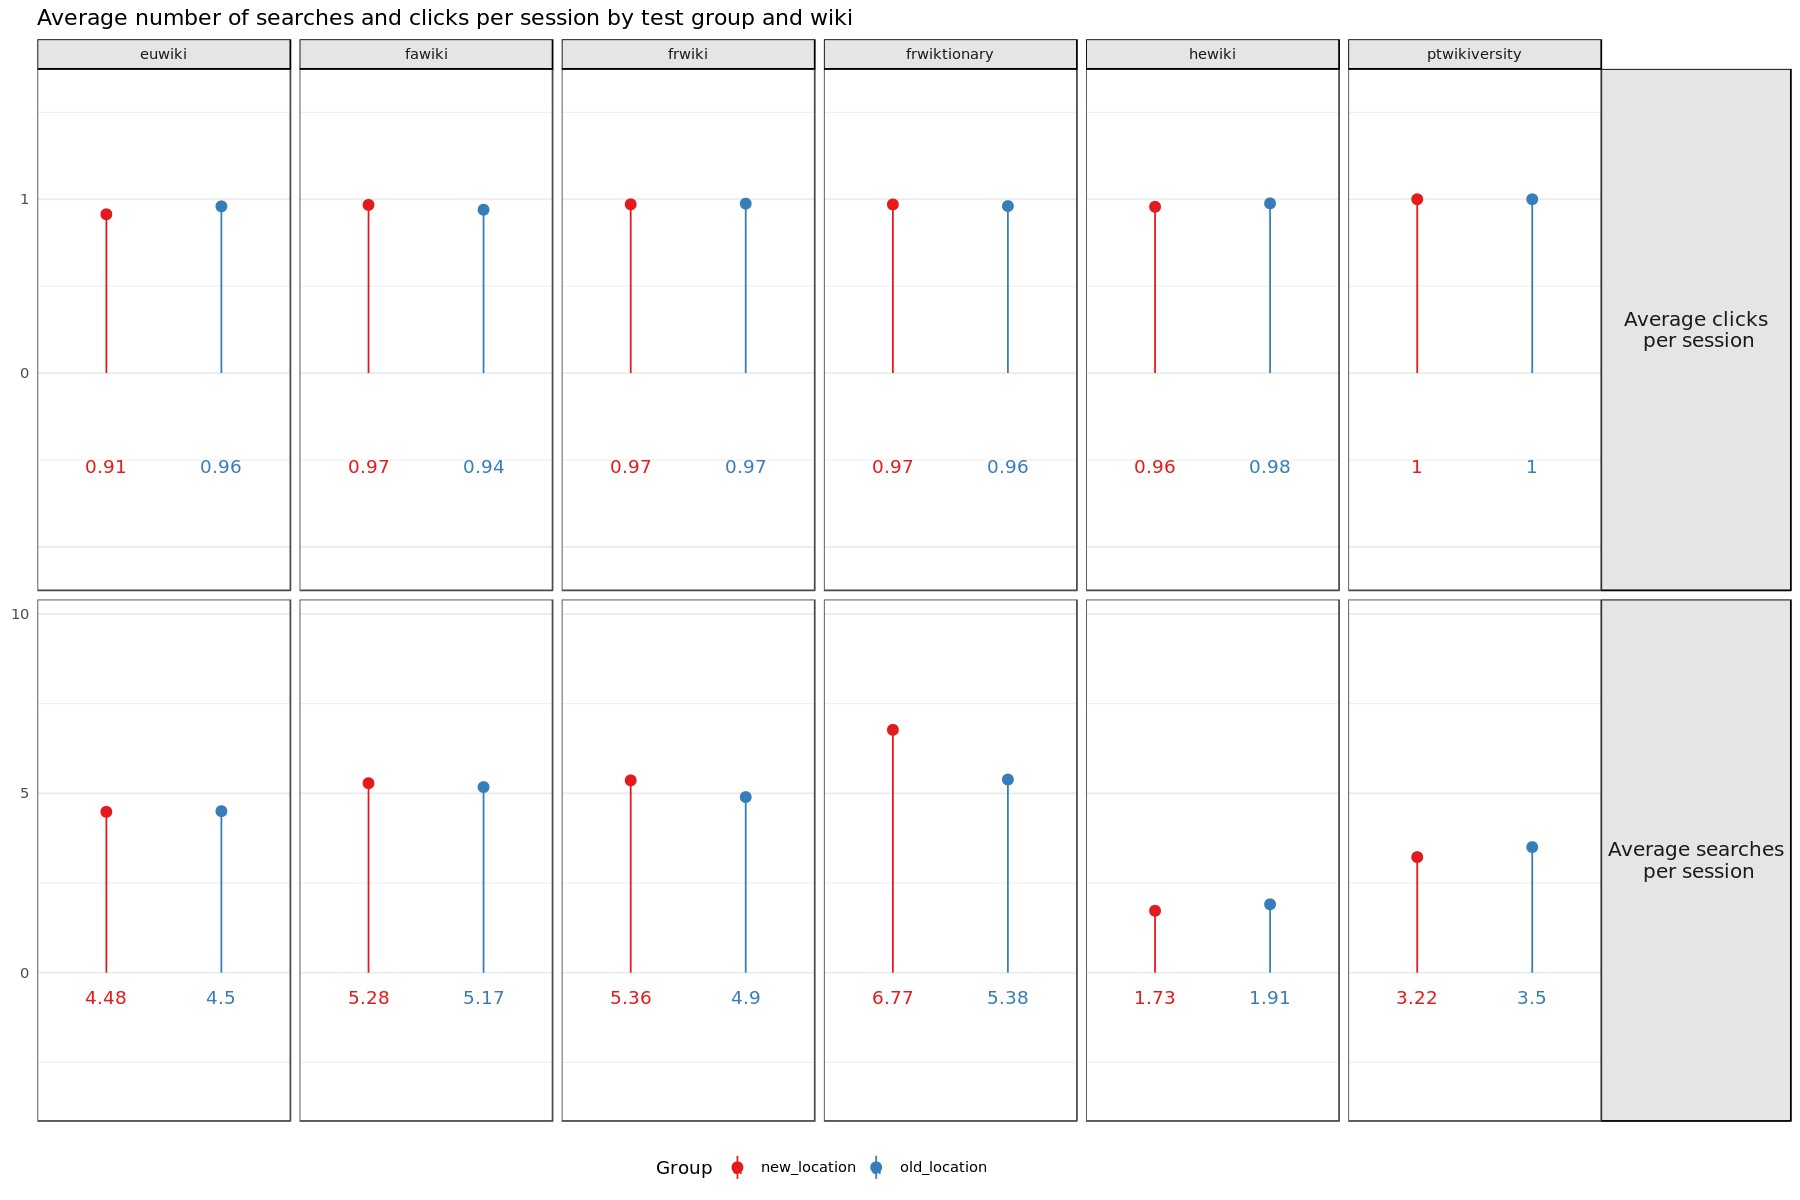

In [37]:
p <- ggplot(searches_counts, aes(x = 1, y = value, color = search_location, ymin = 0, ymax = value)) +
        geom_pointrange(position = position_dodge(width = 0.5)) +
        geom_text(aes(label = (function(values, metrics) {
          return(mapply(function(value, metric) {
          if (grepl("total", metric, fixed = TRUE)) {
            return(polloi::compress(value))
          } else {
        return(round(value, 2))
          }
        }, value = values, metric = metrics))
      })(value, metric), y = -0.5, vjust = "top"),
        position = position_dodge(width = 0.5)) +
      facet_grid(metric ~ search_wiki, scale = "free_y") +
      scale_y_continuous(
      expand = c(0.5, 0),
      labels = function(x) {
      y <- x
      y[x < 0] <- ""
      return(y)
        }
      ) +
      scale_color_brewer("Group", palette = "Set1") +
      theme_minimal(base_family = "GillSans") +
      theme(legend.position = "bottom",
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        strip.background = element_rect(fill = "gray90"),
        panel.border = element_rect(color = "gray30", fill = NA),
        strip.text.y = element_text(size = 12, angle = 0)) +
      labs(x = NULL, y = NULL,
       title = "Average number of searches and clicks per session by test group and wiki")

p
ggsave("Figures/avg_searches_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

## Overall

In [39]:
searches_ctr_overall <- collect_ctr_data  %>%
    filter(results_returned == TRUE,
            is_anonymous == 'false') %>%
    group_by(search_location) %>%
    summarize(searches = sum(search_events), 
            clickthroughs = sum(click_events), .groups = "drop") %>%
    group_by(search_location) %>%
    dplyr::do(binom::binom.bayes(.$clickthroughs, .$searches, conf.level = 0.95))

head(searches_ctr_overall)

search_location,method,x,n,shape1,shape2,mean,lower,upper,sig
<chr>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
new_location,bayes,26992,147746,26992.5,120754.5,0.1826941,0.1807249,0.1846656,0.05000001
old_location,bayes,30065,148981,30065.5,118916.5,0.2018063,0.1997694,0.2038454,0.05000001


In [40]:
bcda_searches_ctr_overall <- searches_ctr_overall %>%
  group_by(method) %>%
  summarize(BCDA::tidy(BCDA::beta_binom(.$x, .$n), interval_type = "HPD"), .groups = "drop") %>%
  ungroup()


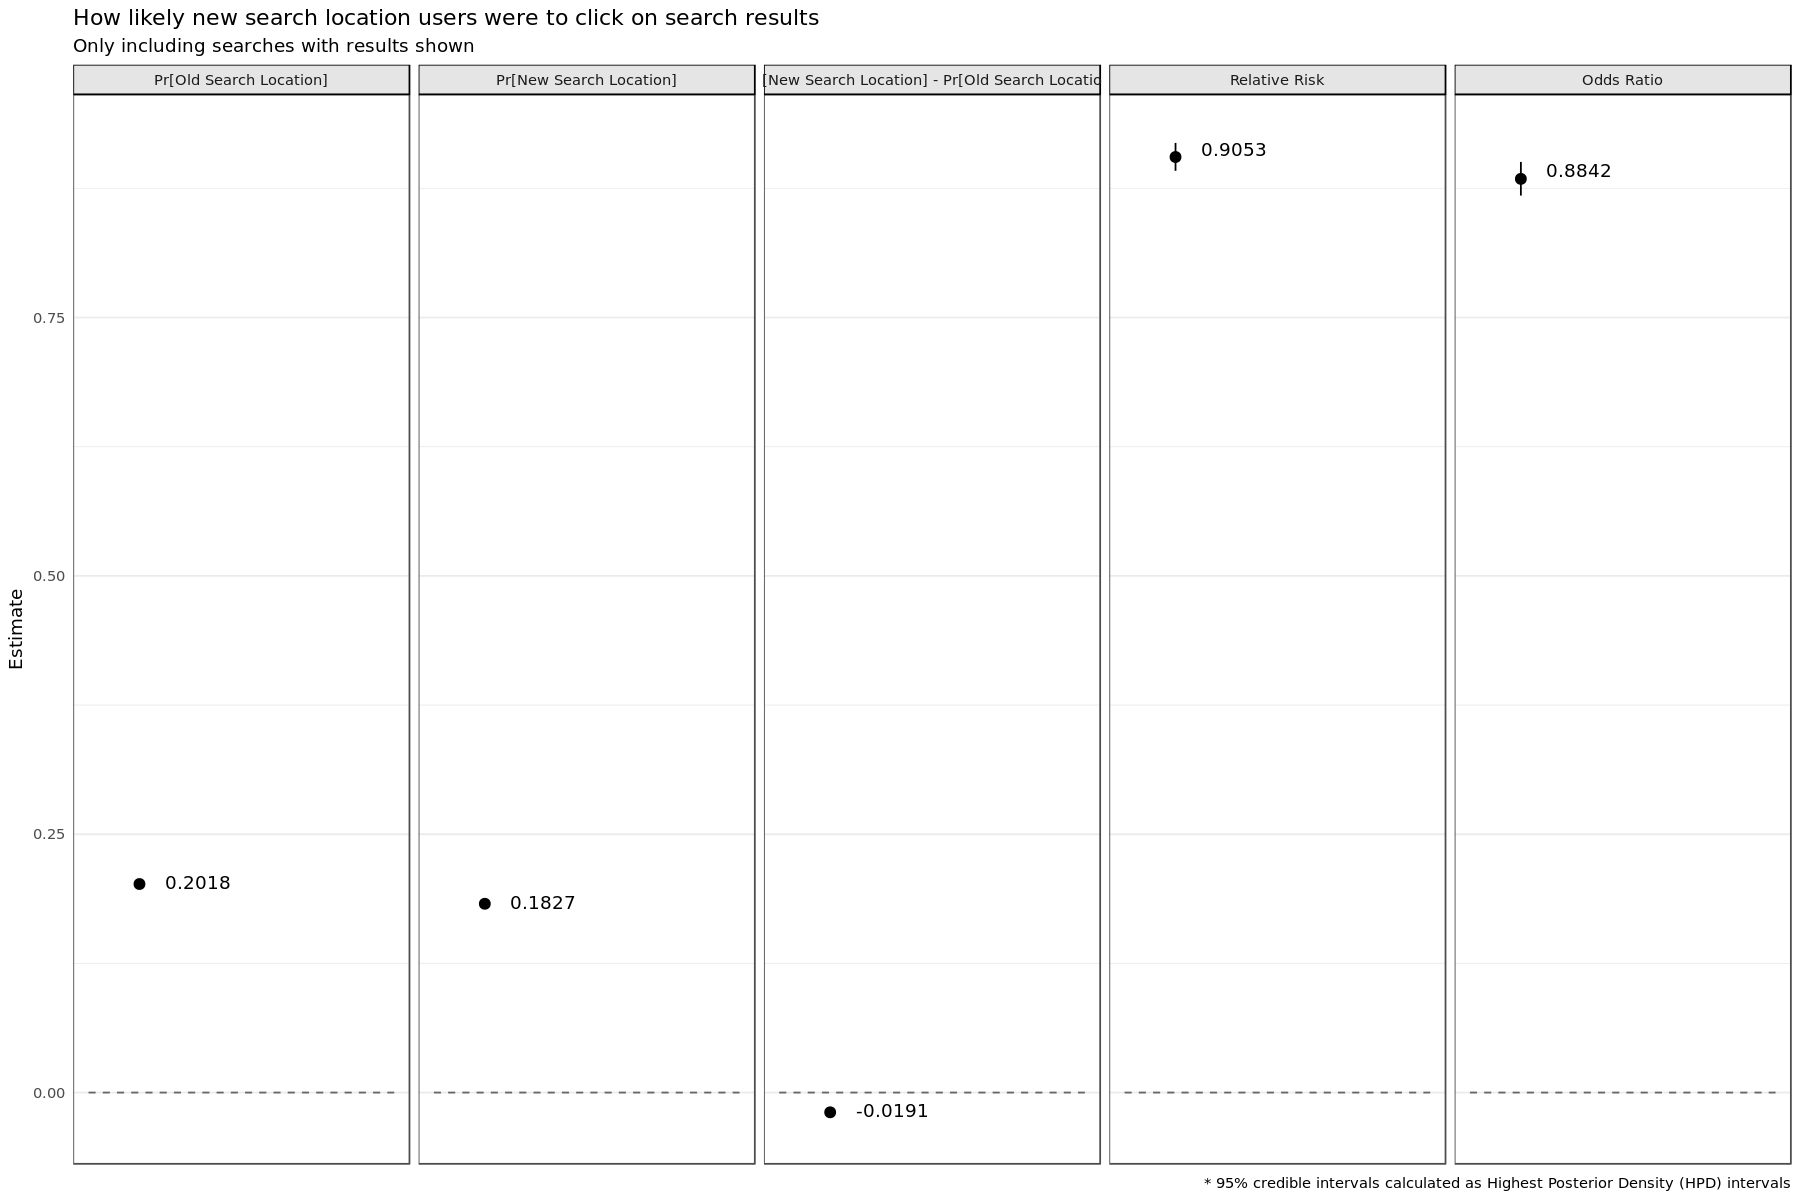

In [41]:
p <- bcda_searches_ctr_overall %>%
  mutate(term = factor(
    term,
    levels = c("p2", "p1", "prop_diff", "relative_risk", "odds_ratio"),
    labels = c("Pr[Old Search Location]", "Pr[New Search Location]", "Pr[New Search Location] - Pr[Old Search Location]", "Relative Risk", "Odds Ratio")
  )) %>%
  ggplot(aes(x = 1, y = estimate, ymin = conf.low, ymax = conf.high)) +
  geom_segment(y = 1, yend = 1, x = 0.99, xend = 1.05, linetype = "dashed", color = "gray40") +
  geom_segment(y = 0, yend = 0, x = 0.99, xend = 1.05, linetype = "dashed", color = "gray40") +
  geom_pointrange() +
  geom_text(aes(label = round(estimate, 4), y = estimate + (conf.high - estimate)/2,
                hjust = "left"), nudge_x = 0.005) +
  facet_grid( ~ term, scales = "free_y") +
  theme_minimal(base_family = "GillSans") +
  scale_x_continuous(limits = c(0.99, 1.05)) +
  theme(legend.position = "bottom",
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        strip.background = element_rect(fill = "gray90"),
        panel.border = element_rect(color = "gray30", fill = NA),
        strip.text.y = element_text(size = 12, angle = 0)) +
  labs(x = NULL, y = "Estimate",
       title = "How likely new search location users were to click on search results",
       subtitle = "Only including searches with results shown",
       caption = "* 95% credible intervals calculated as Highest Posterior Density (HPD) intervals")

p
ggsave("Figures/bcda_searches_ctr_overall.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [42]:
list(
  "Test vs Control" = filter(bcda_searches_ctr_overall, term == "relative_risk")) %>%
     dplyr::bind_rows(.id = "Comparison") %>%
     mutate(ci = sprintf("(%.3f, %.3f)", conf.low, conf.high),
            rr =  sprintf("%.3f", estimate)) %>%
     select(Comparison,
         `Relative Risk` = rr,
         `95% CI` = ci) 

Comparison,Relative Risk,95% CI
<chr>,<chr>,<chr>
Test vs Control,0.905,"(0.892, 0.919)"


Users that saw the new search location are 0.905 times more likely to click on a result in a search.

FIXME: ADD TEST TO EXPAND ON RESULTS

## By Wiki

In [43]:
searches_ctr_bysearches_wiki <- collect_ctr_data  %>%
    filter(results_returned == TRUE,
            is_anonymous == 'false') %>%
    group_by(search_wiki, search_location) %>%
    summarize(searches = sum(search_events), 
            clickthroughs = sum(click_events), .groups = "drop") %>%
    group_by(search_wiki, search_location) %>%
    dplyr::do(binom::binom.bayes(.$clickthroughs, .$searches, conf.level = 0.95))

Warning message in binom::binom.bayes(.$clickthroughs, .$searches, conf.level = 0.95):
“1 confidence interval failed to converge (marked by '*').
  Try changing 'tol' to a different value.”


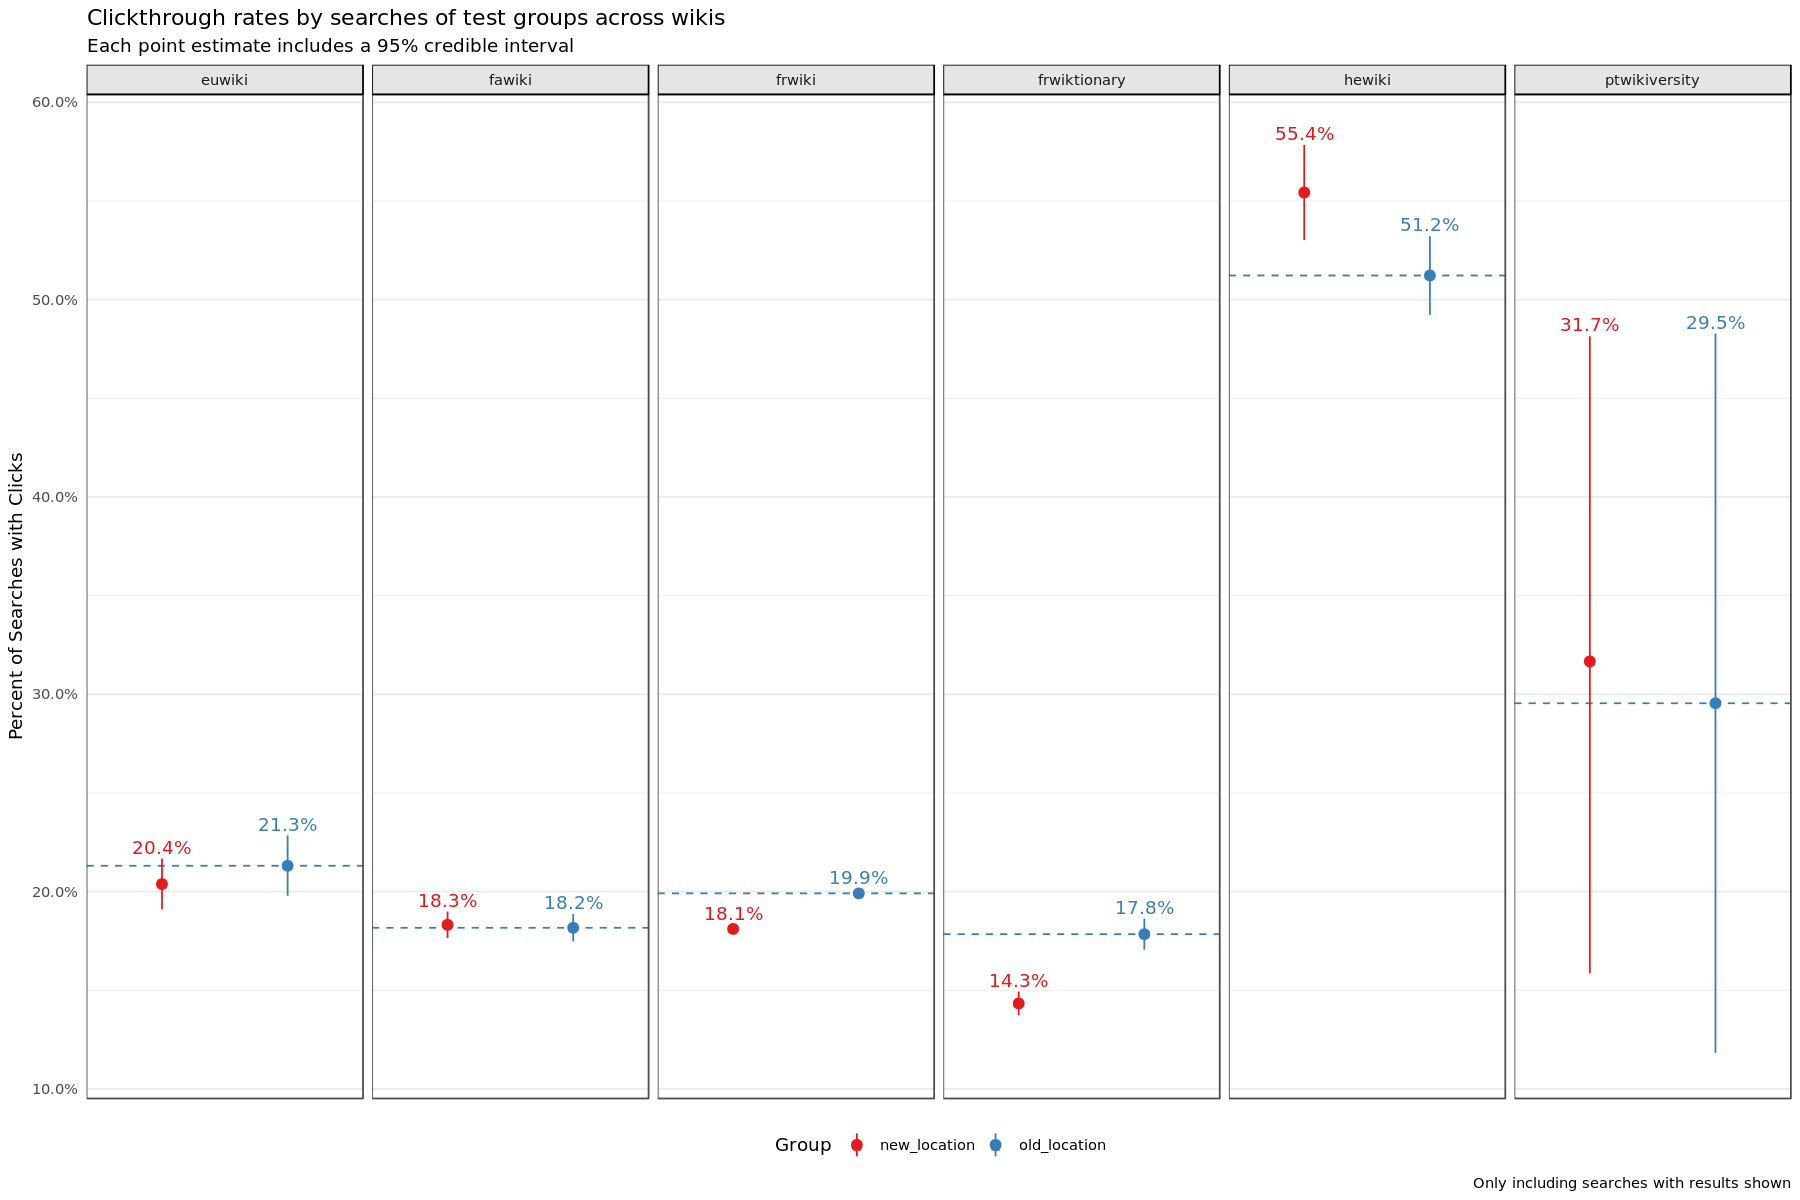

In [47]:
p <- searches_ctr_bysearches_wiki %>%
  ggplot(aes(x = 1, color = search_location, y = mean, ymin = lower, ymax = upper)) +
  geom_hline(aes(yintercept = mean), linetype = "dashed", color = RColorBrewer::brewer.pal(3, "Set1")[2],
             data = filter(searches_ctr_bysearches_wiki , search_location == "old_location")) +
  geom_pointrange(position = position_dodge(width = 0.5)) +
  geom_text(aes(label = sprintf("%.1f%%", 100 * mean), y = upper + 0.0025, vjust = "bottom"),
            position = position_dodge(width = 0.5)) +
  facet_wrap(~ search_wiki, nrow = 1) +
  scale_color_brewer("Group", palette = "Set1") +
  scale_y_continuous("Percent of Searches with Clicks", labels = scales::percent_format()) +
  theme_minimal(base_family = "GillSans") +
  theme(legend.position = "bottom",
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        strip.background = element_rect(fill = "gray90"),
        panel.border = element_rect(color = "gray30", fill = NA)) +
  labs(x = NULL, title = "Clickthrough rates by searches of test groups across wikis",
       subtitle = "Each point estimate includes a 95% credible interval",
       caption = "Only including searches with results shown")
p
ggsave("Figures/searches_ctr_bysearches_wiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [48]:
bcda_ctr_bysearches_wiki <- searches_ctr_bysearches_wiki %>%
  arrange(search_wiki, desc(search_location)) %>%
  group_by(search_wiki) %>%
  dplyr::do(BCDA::tidy(BCDA::beta_binom(.$x, .$n), interval_type = "HPD")) %>%
  ungroup()

In [49]:
p <- bcda_ctr_bysearches_wiki %>%
  mutate(term = factor(
    term,
    levels = c("p2", "p1", "prop_diff", "relative_risk", "odds_ratio"),
    labels = c("Pr[Old Search Location]", "Pr[New Search Location]", "Pr[New Search Location] - Pr[Old Search Location]", "Relative Risk", "Odds Ratio")
  )) %>%
  ggplot(aes(x = 1, y = estimate, ymin = conf.low, ymax = conf.high)) +
  geom_segment(y = 1, yend = 1, x = 0.99, xend = 1.05, linetype = "dashed", color = "gray40") +
  geom_segment(y = 0, yend = 0, x = 0.99, xend = 1.05, linetype = "dashed", color = "gray40") +
  geom_pointrange() +
  geom_text(aes(label = round(estimate, 4), y = estimate + (conf.high - estimate)/2,
                hjust = "left"), nudge_x = 0.005) +
  facet_grid(term ~ search_wiki, scales = "free_y") +
  theme_minimal(base_family = "GillSans") +
  scale_x_continuous(limits = c(0.99, 1.05)) +
  theme(legend.position = "bottom",
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        strip.background = element_rect(fill = "gray90"),
        panel.border = element_rect(color = "gray30", fill = NA),
        strip.text.y = element_text(size = 12, angle = 0)) +
  labs(x = NULL, y = "Estimate",
       title = "How likely new search location users were to engage with search results",
       subtitle = "Only including searches with results shown",
       caption = "* 95% credible intervals calculated as Highest Posterior Density (HPD) intervals")

ggsave("Figures/bcda_ctr_bysearches_wiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [51]:
list(
  "Test vs Control" = filter( bcda_ctr_bysearches_wiki, term == "relative_risk")) %>%
     dplyr::bind_rows(.id = "Comparison") %>%
     mutate(ci = sprintf("(%.3f, %.3f)", conf.low, conf.high),
            rr =  sprintf("%.3f", estimate)) %>%
     select(Wiki = search_wiki, 
         `Relative Risk` = rr,
         `95% CI` = ci) %>%
      arrange(Wiki) 

Wiki,Relative Risk,95% CI
<chr>,<chr>,<chr>
euwiki,1.047,"(0.949, 1.148)"
fawiki,0.992,"(0.942, 1.047)"
frwiki,1.100,"(1.082, 1.119)"
frwiktionary,1.246,"(1.173, 1.327)"
hewiki,0.924,"(0.871, 0.978)"
ptwikiversity,1.006,"(0.263, 1.881)"


FIXME: WRITE-UP ANALYSIS NOTES FOR SECTION ABOVE

# References

Popov, Mikhail. n.d. BCDA: Tools for Bayesian Categorical Data Analysis. https://github.com/bearloga/BCDA.

FIXME: FILL IN OTHER REFERENECES AS NEEDED